In [1]:
%run init_notebook.py

In [2]:
import pandas as pd
import numpy as np

import datetime as dt

In [3]:
from settings import OUT_DATA_DIR, WORK_DATA_DIR, OUT_MODEL_DIR, test_size

In [4]:
from utils.load import load_data, save_model, save_file
from utils.utils import tts_data
from src.src import ModelValidation, StatsTest
from src.models import RandomWalk

In [6]:
# Load data
model_type = "rw"
tinterval = 'daily'

year_start = 2012
year_end = 2021
year_spread = f'years{year_end}_{year_start}'

variables = 'FF_TS_VX' # 'FF' # 'FF_TS_VX'

name = f'{tinterval}_{variables}_{year_spread}'

df_w = load_data(file_name=f"df_{name}.csv", file_path=OUT_DATA_DIR)
data_dict = load_data(file_name=f"dict_{name}.pkl", file_path=OUT_DATA_DIR)

In [7]:
# update dict with model specific information
data_dict["model_features"].update(datetime_ind=dict(zip(df_w.index, df_w.date)))

data_dict["model_metrics"].update(model_type=model_type)
data_dict["model_metrics"].update(variables=variables)
data_dict["model_metrics"].update(tinterval=tinterval)
data_dict["model_metrics"].update(model_name=f"{model_type}_{name}_{data_dict['model_features']['predicted']}")

In [8]:
# select model features
cols = [item for item in data_dict["data"]["relevant_cols"] if "lead" not in item]
cols = [
     'sp_close',
]

categorical = [    
     # 'weekday',
     # 'weekday_0',
     # 'weekday_1',
     # 'weekday_2',
     # 'weekday_3',
     # 'weekday_4'
]

## categorical features
if len(categorical) > 0:
    cols = cols + categorical
    data_dict["model_features"]["categorical"] = categorical

# predictors are all X cols
data_dict["model_features"].update(predictor=[item for item in cols if item != data_dict["model_features"]["predicted"]])

# TTS

In [9]:
df_ws = df_w[cols + [data_dict["model_features"]["predicted"]]].copy()

In [10]:
df_train = df_ws.copy()

In [11]:
X_train, X_test, y_train, y_test = tts_data(df_train,
                                            y=data_dict["model_features"]["predicted"],
                                            x=cols,
                                            random_split=False,
                                            test_size=test_size,
                                            add_const=False)

# Model eval

In [12]:
model = RandomWalk(X_train, X_test)

In [13]:
rval = ModelValidation(X_train, y_train, X_test, y_test, model, print_results=True)

TTest one sample for mean: 0
Test statistics: [2.31746987]
Test pvalue: [0.02056273]
Population mean is equal to 0: [ True]


Testing for zero mean
Time series has a zero mean: True
Random walk requires a drift: False


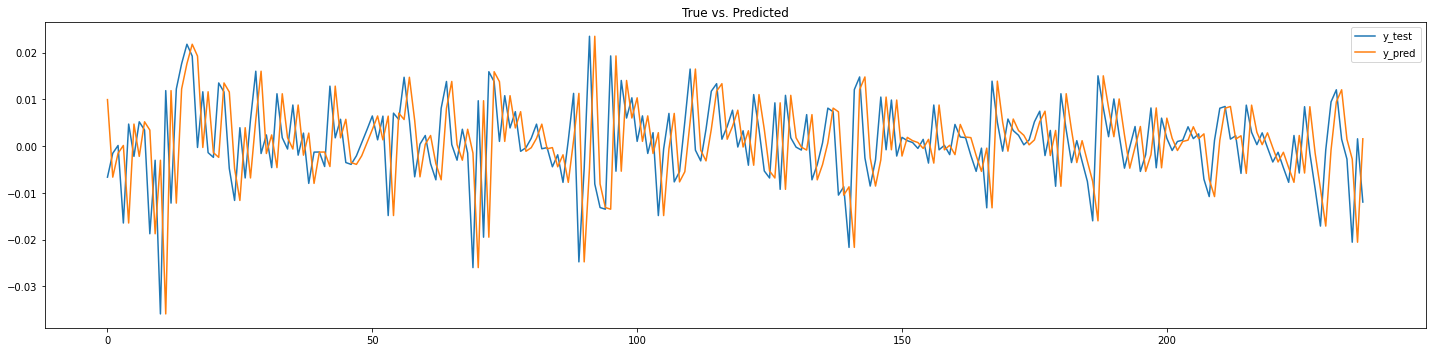

Validation Scores
root mean squared error: 0.0122312705
mean squared error: 0.000149604
mean absolute error: 0.0091704609
R2: -1.0502342265


In [16]:
fig_truefit = rval.get_model_performance()

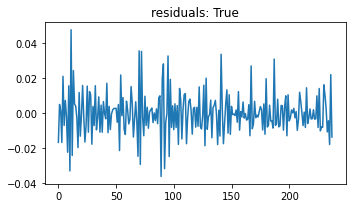

Stationarity Test Results
P-Values: 1.641847377619266e-11
Test-stats: -7.665869921013941
Time series is stationary: True
Number of lags used: 14




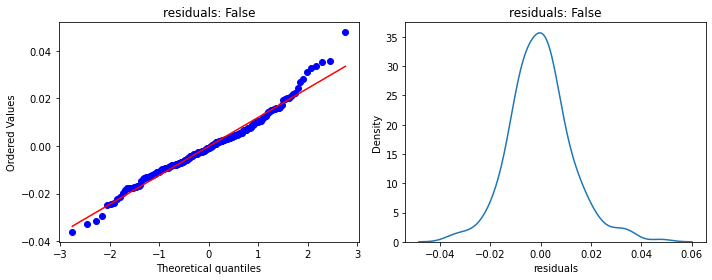

Normality Test Results
P-Values: 0.00021075834431034113
Test-stats: 16.92959673691996
Series is normally distributed: False


HET WHITE TEST REQUIRES A CONSTANT IN X DATA
adding constant to data


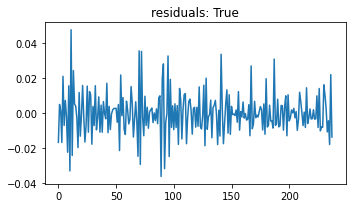

Test for Heteroskedasticity
Test p-value: 2.175070226854132e-27
Heteroskedasticity is present: True


TTest one sample for mean: 0
Test statistics: -0.11601448140301028
Test pvalue: 0.9077393063363235
Population mean is equal to 0: False


Durbin watson test for first oder autocorrelation
Test statistics: 1.5 < 3.026 < 2.5
First order autocorrlation is not present: : False


In [17]:
stat, norm, hetero, d_watson, zero_mean = rval.analyse_resids()

In [18]:
# update dict
# residuals
data_dict["model_metrics"].update(resid_stationarity=stat)
data_dict["model_metrics"].update(resid_normality=norm)
data_dict["model_metrics"].update(resid_heterskedasticity=hetero)
data_dict["model_metrics"].update(d_watson_aucorr=d_watson)

# model performance
data_dict["model_metrics"].update(rmse=rval.rmse)
data_dict["model_metrics"].update(mse=rval.mse)
data_dict["model_metrics"].update(mae=rval.mae)
data_dict["model_metrics"].update(r2=rval.r2)
data_dict["model_metrics"].update(residuals=rval.resid_inv)

# Save model

In [19]:
save_model(model=rval.model_wrapper, 
           df_train=df_train,
           data_dict=data_dict,
           plt_figures=[fig_truefit], 
           fig_titles=['fig_truefit',], model_dir=OUT_MODEL_DIR)

Are you sure you want to save model as: f"2022-04-05_rw_daily_FF_TS_VX_years2021_2012_sp_close_lead1"? (y/n)


 y
